In [2]:
# install BLADE with !pip install iohblade

from iohblade.loggers import ExperimentLogger
from iohblade import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


def plot_landscape(row, bounds=(-5, 5), res=200):
    """
    row  : one row of the dataframe (df.loc[idx] or df.iloc[idx])
    bounds: (low, high) tuple applied to both axes
    res   : grid resolution per axis
    """
    # Re-create the callable from the code string
    ns = {}
    exec(row["code"], ns)                      # defines class with same name as row["name"]
    f   = getattr(ns[row["name"]](dim=2), "f")      # instantiate & grab its .f method

    # Grid
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[0], bounds[1], res)
    X, Y = np.meshgrid(x, y)
    pts   = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z     = np.apply_along_axis(f, 1, pts).reshape(X.shape)   # robust fallback

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Landscape of {row['name']}")
    plt.colorbar(cs, ax=ax, label="f(x)")
    plt.tight_layout()
    return fig, ax

logger = ExperimentLogger('../results/ELA_experiment', True)
# logger.add_read_dir('../results/kerneltuner-o4')
# logger.add_read_dir('../results/kerneltuner-o4-no-info')

In [3]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)



['LLaMEA-devstral_24b', 'LLaMEA-mathstral_7b', 'LLaMEA-qwen2.5-coder_14b', 'LLaMEA-gpt-5-nano', 'LLaMEA-gemini-2.0-flash', 'LLaMEA-gpt-5-nano-sharing', 'LLaMEA-qwen2.5-coder_14b-sharing']
['multimodal_structure', 'basins_separable']


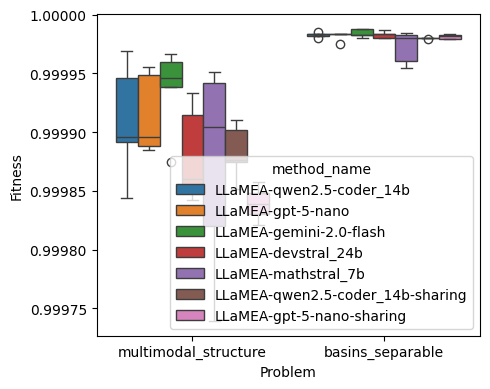

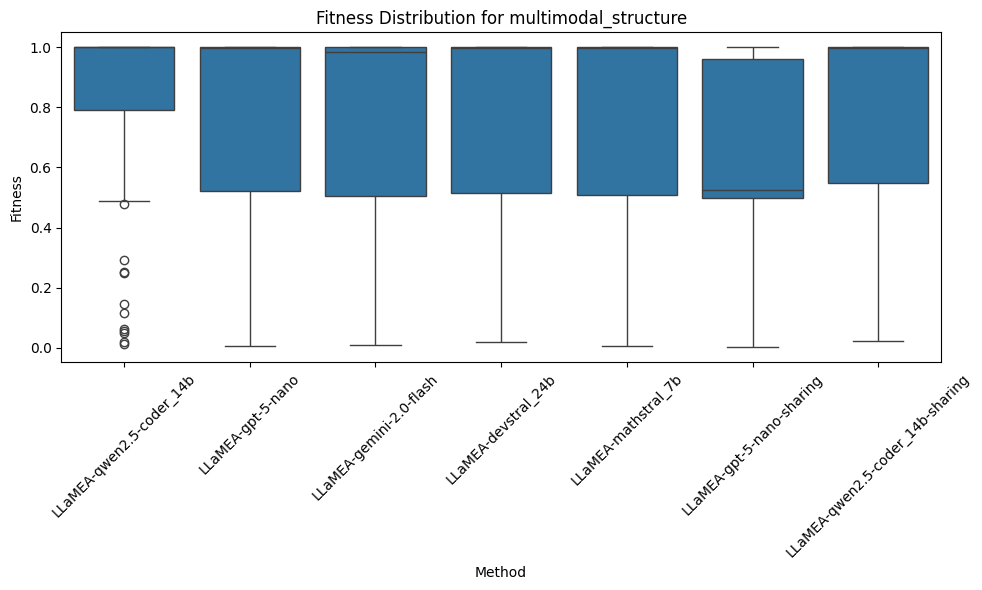

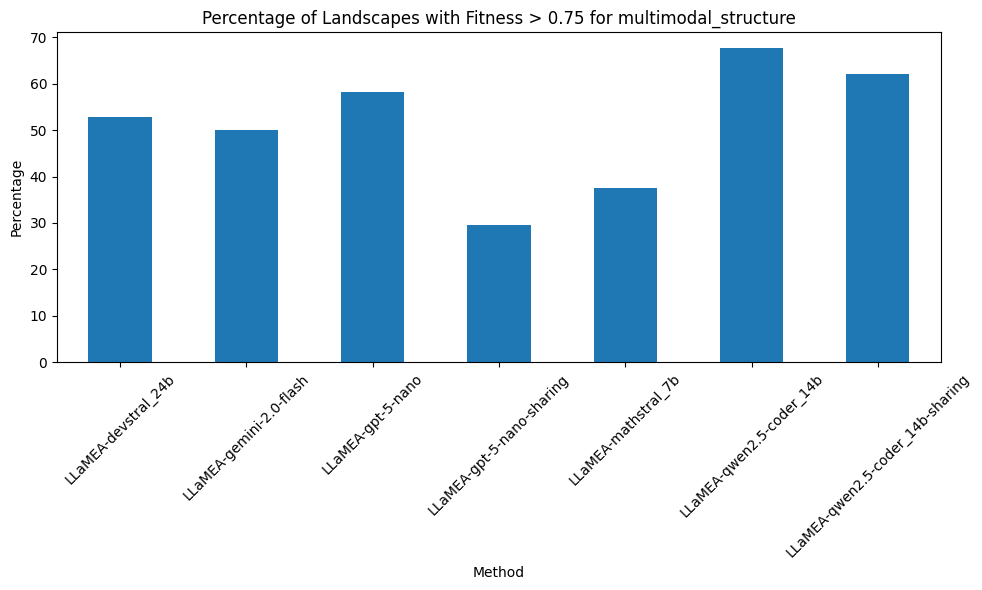

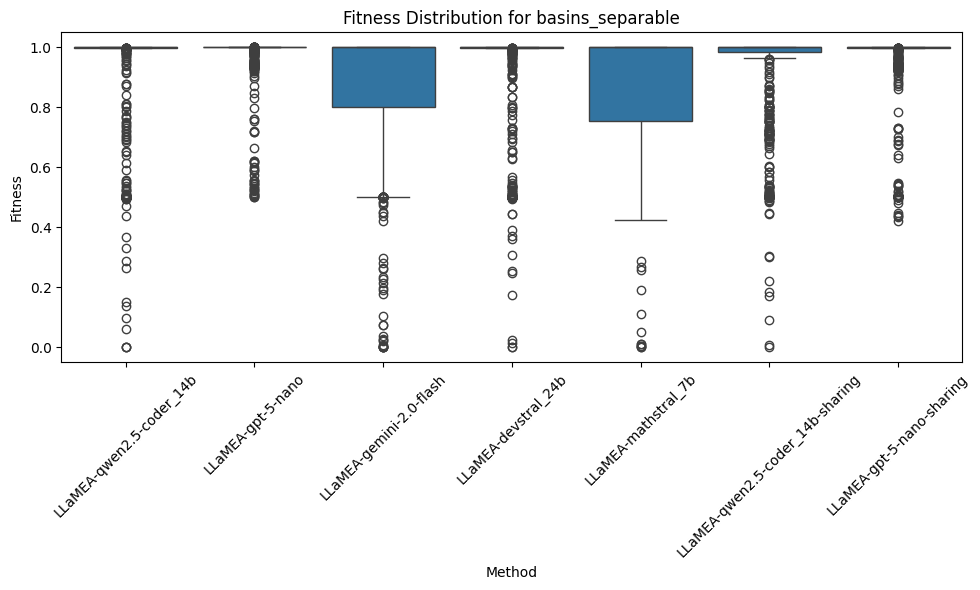

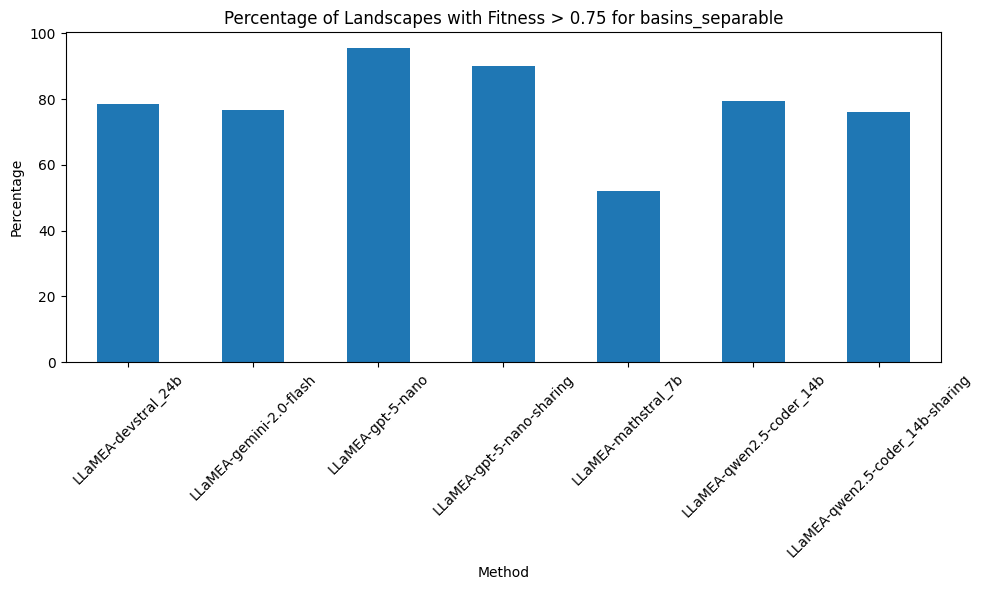

In [4]:

#plot_convergence(logger, metric="fitness", save=False, budget=100)
plot_boxplot_fitness_hue(logger)


methods, problems = logger.get_methods_problems()
for problem in problems:
    data = logger.get_problem_data(problem_name=problem)
    if problem == "basins_separable":
        # The fitness values are wrong for this problem, we can fix them though, fitness should be score_basins_scaled + (score_separable_scaled + 99) / 100
        # We should check for each method and seed if the score_separable_scaled is negative, if so we can use the formula above
        for method in methods:
            if method not in data['method_name'].values:
                continue
            seeds = data[data['method_name'] == method]['seed'].unique()
            for seed in seeds:
                subset_idx = data.index[(data['method_name'] == method) & (data['seed'] == seed)]
                meta_df = pd.json_normalize(data.loc[subset_idx, 'metadata'])
                if len(meta_df[meta_df['score_separable_scaled'] < 0]) > 0:
                    m = (data['method_name'] == method) & (data['seed'] == seed)

                    sep = data.loc[m, 'metadata'].apply(lambda d: d.get('score_separable_scaled', float('-inf')))
                    bas = data.loc[m, 'metadata'].apply(lambda d: d.get('score_basins_scaled', float('-inf')))

                    calc = (bas + (sep + 99) / 100) / 2

                    data.loc[m, 'fitness'] = calc.to_numpy()
                    
    # create a boxplot to show fitness distribution per method
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=data, x='method_name', y='fitness', ax=ax)
    ax.set_title(f"Fitness Distribution for {problem}")
    ax.set_xlabel("Method")
    ax.set_ylabel("Fitness")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # now count the number of landscapes with a fitness above 0.75 per method and show this as a bar plot
    counts = data[data['fitness'] > 0.75].groupby('method_name').size() / data.groupby('method_name').size() * 100  # percentage
    fig, ax = plt.subplots(figsize=(10, 6))
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"Percentage of Landscapes with Fitness > 0.75 for {problem}")
    ax.set_xlabel("Method")
    ax.set_ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


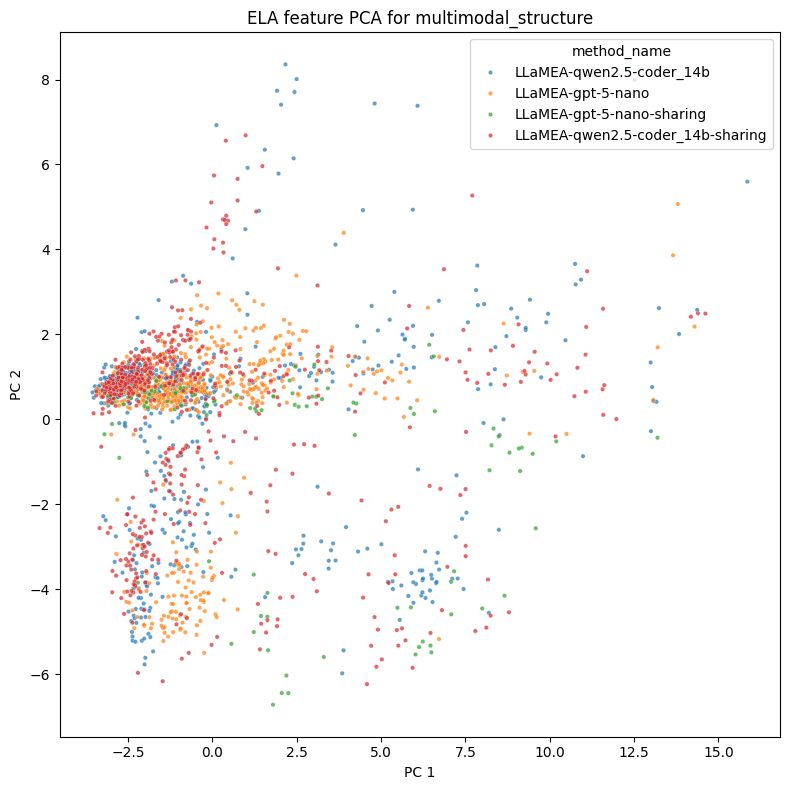

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

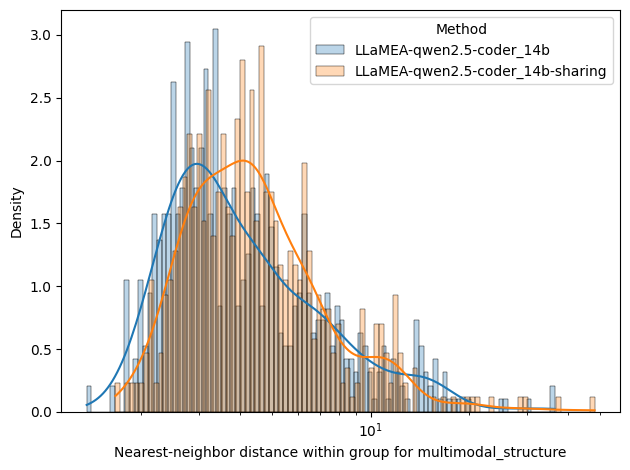

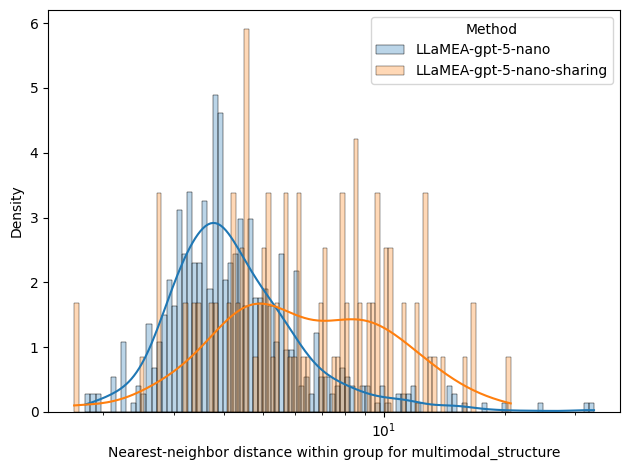

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


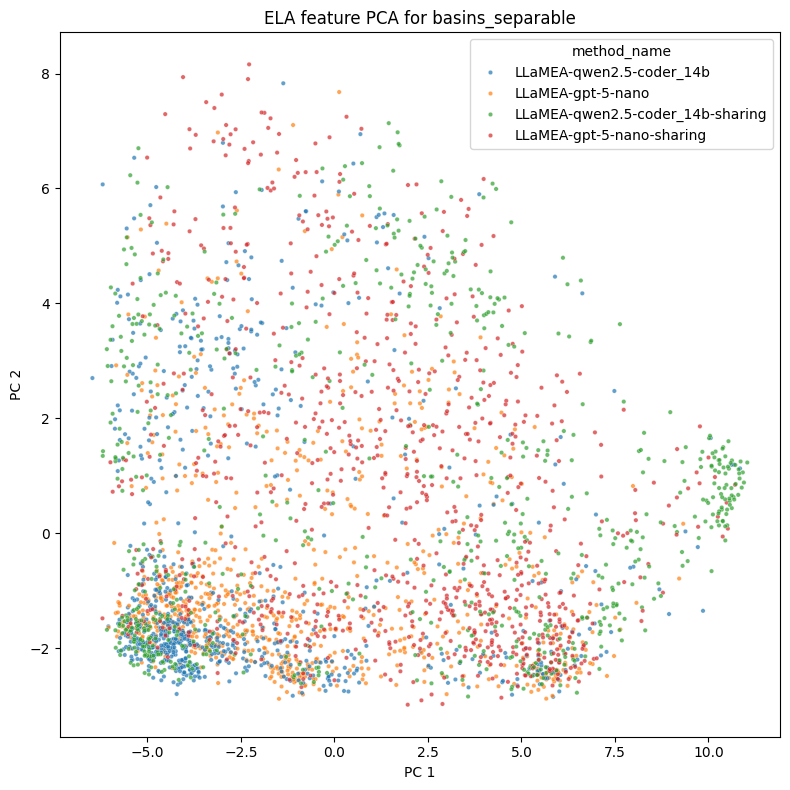

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

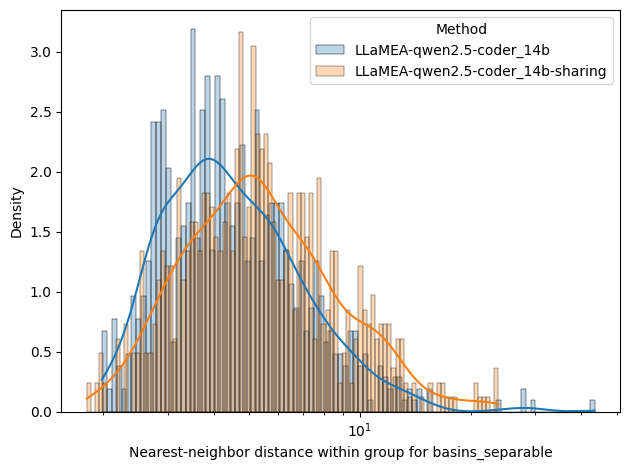

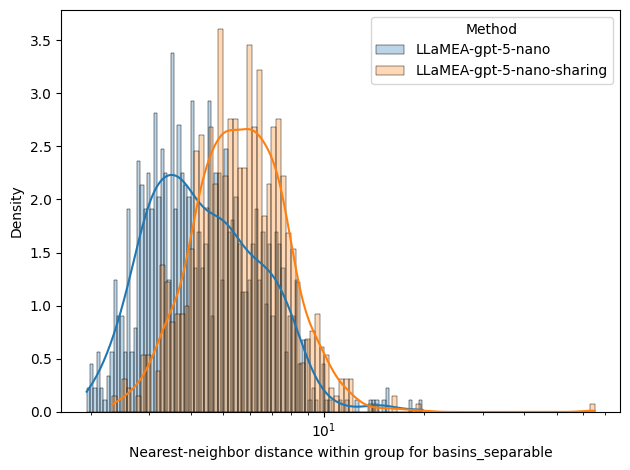

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import joblib

def _plot_on_ax(row, ax, bounds=(-5, 5), res=300):
        ns = {}
        exec(row["code"], ns)
        f = getattr(ns[row["name"]](dim=2), "f")

        x = np.linspace(*bounds, res)
        y = np.linspace(*bounds, res)
        X, Y = np.meshgrid(x, y)
        Z = np.apply_along_axis(f, 1, np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)

        cs = ax.contour(X, Y, Z, levels=40, linewidths=0.6)
        #ax.clabel(cs, cs.levels[::2], inline=True, fontsize=6, fmt="%.2g")  # optional labels

        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"{row['name']}", fontsize=7)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.0)

def min_intragroup_distances(df, group_col, num_cols):
    """
    For each row, compute the distance to its nearest neighbor *within the same group*.
    Returns a Series aligned to df.index with NaN for groups of size 1.
    """
    X = df[num_cols].astype(float).copy()
    out = pd.Series(np.nan, index=df.index, name="min_intragroup_dist")

    for gval, g in df.groupby(group_col, sort=False):
        Xi = X.loc[g.index].to_numpy()
        n = len(Xi)
        if n < 2:
            continue
        # pairwise Euclidean distances
        dists = pairwise_distances(Xi, metric='cityblock')
        # Set diagonal to np.inf to ignore self-distances
        np.fill_diagonal(dists, np.inf)
        mins = dists.min(axis=1)
        out.loc[g.index] = mins
        # clip outliers
        # out.loc[g.index] = np.clip(out.loc[g.index], 0, 100)
        # make values too close to zero, 0.01
        out.loc[g.index] = np.where(out.loc[g.index] < 0.1, 0.1, out.loc[g.index])

    return out


# Train a standard scaler
if False:
    all_ela_data = []

    for problem in problems:
        data = logger.get_problem_data(problem_name=problem)
        meta_df = pd.json_normalize(data['metadata'])
        meta_df["ela_features"] = meta_df["ela_features"].apply(
            lambda v: v[0] if isinstance(v, (list, tuple)) and len(v) == 1 else v
        )
        #remove nans and infs
        meta_df = meta_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ela_features"])

        ela_mat = np.vstack(meta_df["ela_features"].values)
        all_ela_data.append(ela_mat)

    # combine into one big matrix
    all_ela_data = np.vstack(all_ela_data)

    # remove inf and NaN
    all_ela_data = np.where(np.isfinite(all_ela_data), all_ela_data, np.nan)
    mask = ~np.isnan(all_ela_data).any(axis=1)
    all_ela_data = all_ela_data[mask]

    # fit one scaler
    scaler = StandardScaler().fit(all_ela_data)
    joblib.dump(scaler, "ela_scaler.joblib")


for problem in problems:
    data = logger.get_problem_data(problem_name=problem)



    # Filter the best fitness values above 0.75 threshold
    #print(data["fitness"].describe())
    meta_df = pd.json_normalize(data['metadata'])
    if problem == "basins_separable":
        index_mask = (meta_df['score_basins_scaled'] > 0.5) & (meta_df['score_separable_scaled'] > 0.5)
    elif problem == "multimodal_structure":
        index_mask = (meta_df['score_multimodal_scaled'] > 0.5) & (meta_df['score_structure_scaled'] > 0.5)

    df_best = data.loc[index_mask].copy()
    meta_df = meta_df.loc[index_mask].copy()

    #print(meta_df.columns)

    meta_df["ela_features"] = meta_df["ela_features"].apply(lambda v: v[0] if isinstance(v, (list, tuple)) and len(v)==1 else v)

    # -- explode into separate numeric columns
    ela_mat = np.vstack(meta_df["ela_features"].values)
    ela_cols = [f"ela_{i}" for i in range(ela_mat.shape[1])]
    ela_df   = pd.DataFrame(ela_mat, columns=ela_cols, index=meta_df.index)

    df = pd.concat([df_best, ela_df], axis=1)
    #remove inf values from ela_cols dataframe
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=ela_cols)

    #print(df.columns)
    scaler = joblib.load(f"ela_scaler.joblib")

    

    
    #pc = TSNE(n_components=2, learning_rate='auto',
    #              init='random', perplexity=6).fit_transform(X_scaled)

    #filter on method_name
    df_gpt5 = df[df["method_name"].str.contains("gpt-5") | df["method_name"].str.contains("qwen")]
    X_scaled = scaler.transform(df_gpt5[ela_cols])
    pc = PCA(n_components=2).fit_transform(X_scaled)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=df_gpt5["method_name"], ax=ax, s=10, alpha=0.7) #palette="viridis", 
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_title(f"ELA feature PCA for {problem}")
    #plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.clf()



    # Now get some numerical diversity metrics on the ELA features per method
    df[ela_cols] = scaler.transform(df[ela_cols])
    min_d = min_intragroup_distances(df, "method_name", ela_cols)
    #print(min_d.head())
    #print(min_d.describe())
    

    
    # Plot: histogram of min distances, colored per group qwen
    plt.figure()
    bins = 100  # tune as needed
    for gval, s in min_d.groupby(df["method_name"]):
        if "qwen2.5" not in gval:
            continue
        vals = s.dropna().to_numpy()
        if len(vals) == 0:
            continue
        #print(np.max(vals), "max ela dist", str(gval))
        sns.histplot(vals, bins=bins, log_scale=True, alpha=0.3, label=str(gval), kde=True, stat="density")  # kde=True adds a kernel density estimate
        #plt.hist(vals, bins=bins, alpha=0.5, label=str(gval), density=True)  # density normalizes for different group sizes
    plt.xlabel(f"Nearest-neighbor distance within group for {problem}")
    plt.ylabel("Density")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()


    # Plot: histogram of min distances, colored per group for gpt-5
    plt.figure()
    bins = 100  # tune as needed
    for gval, s in min_d.groupby(df["method_name"]):
        if "gpt-5" not in gval:
            continue
        vals = s.dropna().to_numpy()
        if len(vals) == 0:
            continue
        #print(np.max(vals), "max ela dist", str(gval))
        sns.histplot(vals, bins=bins, log_scale=True, alpha=0.3, label=str(gval), kde=True, stat="density")  # kde=True adds a kernel density estimate
        #plt.hist(vals, bins=bins, alpha=0.5, label=str(gval), density=True)  # density normalizes for different group sizes
    plt.xlabel(f"Nearest-neighbor distance within group for {problem}")
    plt.ylabel("Density")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()


    # Now for each method, for the landscapes with the highest ela distance, plot the landscape using plot_landscape
    # attach distances to df for convenience
    df2 = df.copy()
    df2["min_intragroup_dist"] = min_d

    if False: #plot landscapes

        for method, grp in df2.groupby("method_name", sort=False):
            top = grp.nlargest(36, "min_intragroup_dist")  # preserves original df index
            #print(method, top[["min_intragroup_dist"]])

            try:
                rows, cols = 6, 6
                fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), dpi=300)

                for ax in axes.ravel():
                    ax.axis("off")           # blank everything first

                for ax, (_, row) in zip(axes.ravel(), top.iterrows()):
                    _plot_on_ax(row, ax, bounds=(-5, 5), res=200)

                fig.suptitle(f"Most seperate landscapes {problem} for {method}")
                plt.tight_layout()
                plt.show()
                plt.savefig(f"landscapes_{problem}_{method}.pdf")
                plt.clf()
            except Exception as e:
                print(f"plot failed: {e}")

